In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
import matplotlib

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm import tqdm
matplotlib.rcParams['figure.figsize'] = [15, 15]

In [2]:
# constants
data_path = '/home/raghukul/github/Time_Series_Project/Data/apple_share_price.csv'

In [3]:
# FOR REPRODUCIBILITY
np.random.seed(7)

In [4]:
# IMPORTING DATASET 
dataset = pd.read_csv('../Data/apple_share_price.csv', usecols=[1,2,3,4])

In [5]:
# TAKING DIFFERENT INDICATORS FOR PREDICTION
ts_data = dataset.mean(axis = 1) # aka OHLC
n_samples = len(ts_data)

## Relative Ordering Test - kendalls coefficient

In [ ]:
def kendall_coeff(ts_data, n):
    count = 0
    for i in tqdm(range(n)):
        for j in range(i+1, n):
            if(ts_data[i] > ts_data[j]):
                count += 1
    coeff = 1 - 4.0*count/((n)*(n-1.0))
    var   = (2.0*(2*n + 5.0))/((9.0*n*(n-1.0)))
    
    return coeff, var, coeff/var**0.5

In [18]:
kendall_coeff(ts_data.values, n_samples)
# if observed statistics is greater than 1.96 (tau alpha/2), then we reject null hypothesis
# trend present

100%|██████████| 1664/1664 [00:00<00:00, 3673.93it/s]


(0.6832502659697488, 0.0002676561512250027, 41.7629525799875)

## Parametric F test

In [106]:
def poly_trend(Y_data, n, k):
    X_data = [[] for i in range(n)]
    for i in range(n):
        for j in range(k):
            X_data[i].append(pow(i, j))
    model = LinearRegression(fit_intercept=True)
    model.fit(X_data, Y_data)
    pred = model.predict(X_data)
    return model, pred

In [116]:
model, pred = poly_trend(ts_data, len(ts_data), 2)
new_data = [ts_data[i]-pred[i] for i in range(len(ts_data))]

In [108]:
np.asarray(new_data).std()

10.505020429613902

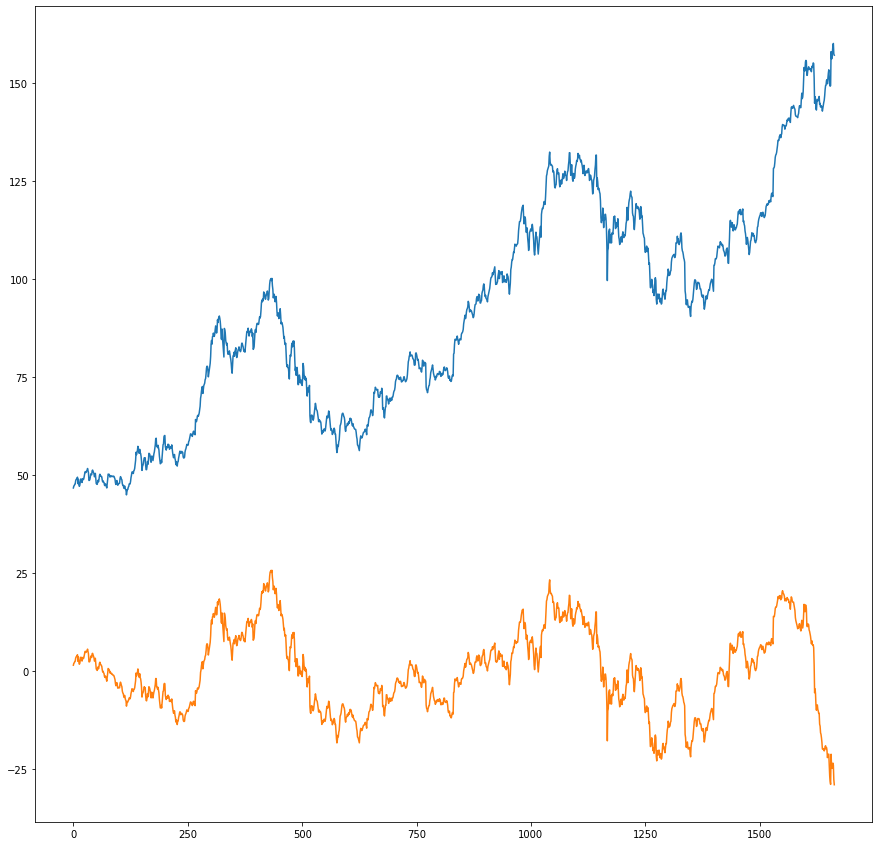

In [113]:
# at k = 7(6 degree trend), get lowest variance
plt.plot(ts_data)
plt.plot(new_data)

## Test for randomness

In [135]:
def randomness(ts_data):
    count = 0
    n = len(ts_data)
    for i in range(1, n-1):
        if(ts_data[i] > ts_data[i-1] and ts_data[i] > ts_data[i+1]):
            count += 1
        if(ts_data[i] < ts_data[i-1] and ts_data[i] < ts_data[i+1]):
            count += 1
    exp_q = (n-2.0)*(2/3.0)
    var_q = (16.0*n-29.0)/90.0
    z = (count - exp_q)/(var_q**0.5)
    return abs(z)

In [137]:
diff = []
for i in range(1, len(ts_data)):
    diff.append(ts_data[i] - ts_data[i-1])

In [132]:
diff2 = []
for i in range(1, len(diff)):
    diff2.append(diff[i] - diff[i-1])

In [138]:
# level 2 differencing gives best value
randomness(diff2)

1.5910187260149278